In [71]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [72]:
df = pd.read_csv("data/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [73]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [74]:
# train / test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [75]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [76]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [77]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [79]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [80]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [81]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

pipeline_rf = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline_gbr = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(random_state = 42)),
])

pipeline_lr = Pipeline([
    ('features',feats),
    ('classifier', LinearRegression()),
])

In [82]:
# learning

In [83]:
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [84]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                ('Age',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('classifier', LinearRegression())])

In [85]:
pipeline_gbr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('classifier', GradientBoostingRegressor(random_state=42))])

In [86]:
preds_rf = pipeline_rf.predict_proba(X_test)[:, 1]
preds_rf[:5]

array([0.37, 0.26, 0.16, 0.02, 0.02])

In [87]:
preds_gbr = pipeline_gbr.predict(X_test)
preds_gbr[:5]

array([0.285323  , 0.2287051 , 0.23499639, 0.10897917, 0.0027722 ])

In [88]:
preds_lr = pipeline_lr.predict(X_test)
preds_lr[:5]

array([0.277819  , 0.32988139, 0.19696902, 0.14171299, 0.20778765])

In [89]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [90]:
# randomForest
precision, recall, thresholds = precision_recall_curve(y_test, preds_rf)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


In [91]:
# gradientBoostingRegressor
precision, recall, thresholds = precision_recall_curve(y_test, preds_gbr)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.360223, F-Score=0.646, Precision=0.665, Recall=0.629


In [92]:
# linearRegression
precision, recall, thresholds = precision_recall_curve(y_test, preds_lr)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.287972, F-Score=0.513, Precision=0.431, Recall=0.635


In [93]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1793  198]
 [ 178  331]]


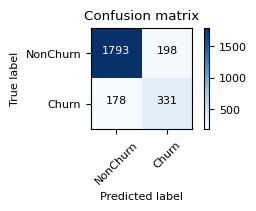

In [111]:
# f_score RF
font = {'size' : 8}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_rf>thresholds[ix])
plt.figure(figsize=(3, 2))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

Confusion matrix, without normalization
[[1828  163]
 [ 189  320]]


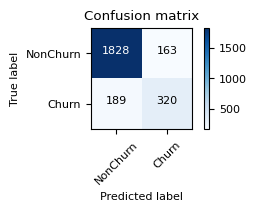

In [112]:
# f_score GBR
font = {'size' : 8}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_gbr>thresholds[ix])
plt.figure(figsize=(3, 2))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

Confusion matrix, without normalization
[[1777  214]
 [ 290  219]]


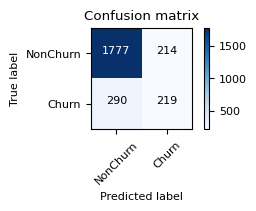

In [113]:
# f_score LR
font = {'size' : 8}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_lr>thresholds[ix])
plt.figure(figsize=(3, 2))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.show()

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Age'))])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('classifier', GradientBoostingRegressor(random_state=42))])

Conclusion: Best -> GradientBoostingRegressor

In [107]:
from sklearn.model_selection import GridSearchCV

params={'classifier__n_estimators': [80, 100, 120],
        'classifier__min_samples_leaf': [1, 2, 3],
        'classifier__min_samples_split': [2, 3, 4],
        'classifier__max_depth': [2, 3, 4],
        'classifier__max_leaf_nodes': [2, 3, 4]
        }

grid = GridSearchCV(estimator=pipeline_gbr, param_grid=params, cv=6, refit=False)

# Выполните поиск по сетке
search = grid.fit(X_train, y_train)

# Выведите лучшие параметры
print(search.best_params_)

{'classifier__max_depth': 3, 'classifier__max_leaf_nodes': 4, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 120}


In [108]:
pipeline_gbr = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingRegressor(random_state = 42,
                                             max_depth=3,
                                             max_leaf_nodes=4,
                                             min_samples_leaf=3,
                                             min_samples_split=2,
                                             n_estimators=120
                                             ))
])

pipeline_gbr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenu...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance'))])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts'))])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary'))]))])),
                ('classifier',
                 GradientBoostingRegressor(max_leaf_nodes=4, min_samples_leaf=3,
                                           n_estimators=120,
                                           random_state=42))])

Best Threshold=0.359328, F-Score=0.644, Precision=0.665, Recall=0.625
Confusion matrix, without normalization
[[1831  160]
 [ 192  317]]


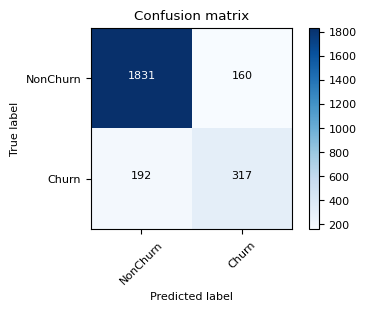

In [114]:
preds = pipeline_gbr.predict(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 8}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(4, 3))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("img/conf_matrix.png")
plt.show()

conclusion:
* 2€ give for every faithful churn
* -1€ pay for every charn


- 1831 - NonChurn True (ignore this)
- 317 - Churn True (paid this)
- 192 - Churn False (need NonChurn True, but we paid this)
- 160 - NonChurn False (need churn True, but we ignore this)

Churn sum: 317 + 192 = 509 => 509 * (-1$) = -509$
Churn true: 317 => 317 * 2$ = 634$
Total: 634 - 509 = 25$

Model give: 25/634 => 0.039 => 3.9% profit